# Pathway Analysis with PathSingle

In [1]:
%reload_ext autoreload
%autoreload 2
import scanpy as sc
import pandas as pd
from metrics import *
from activity import *
import scprep
import magic
from warnings import filterwarnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.decomposition import PCA


filterwarnings('ignore')

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 pynndescent==0.5.13


### Data Preparation
The challenge data is available on AWS cloud servers. You need to register to the challenge here:
- https://www.topcoder.com/challenges/25f60820-2e69-444b-bc03-490686af2c87?tab=details

and then go the the forum links and download sc_training.h5ad from:

- https://discussions.topcoder.com/discussion/25381/challenge-specifications-and-data-for-cancer-immunotherapy-data-science-grand-challenge

In [22]:
adata = sc.read_h5ad('./data/sc_training.h5ad')
adata = sc.pp.subsample(adata, fraction=0.1, copy=True)
#28697 cells × 15077 genes.
adata

AnnData object with n_obs × n_vars = 2869 × 15077
    obs: 'gRNA_maxID', 'state', 'condition', 'lane'
    layers: 'rawcounts'

adata.X stores the standard-normalized data. We can also reconstruct it using adata.layers['rawcounts'].
- Make a copy of X:
```
    adata.layers['normalized_logcounts'] = adata.X.copy()
```
- Use rawcounts for standard normalization:
```
    adata.X = adata.layers['rawcounts'].copy()
    sc.pp.normalize_total(adata, target_sum=5e3)
    sc.pp.log1p(adata)
    adata.raw.X[:5,:5].toarray()
```
We prefer using rawcounts for magic imputation.

In [23]:
adata.X = adata.layers['rawcounts'].copy()
adata.obs.head()

,gRNA_maxID,state,condition,lane
053l3_GTACTTTGTCGAATCT-1,ONE-NON-GENE-SITE-6,cycling,Unperturbed,lane3
053l4_AAGTCTGAGCCAGTTT-1,Ikzf3-3,terminal exhausted,Ikzf3,lane4
053l4_TGCACCTCAGCCAGAA-1,Rela-3,effector,Rela,lane4
053l3_CCACTACCATCGGTTA-1,Dvl2-3,effector,Dvl2,lane3
053l2_CGGTTAAGTGCTCTTC-1,Tox2-3,terminal exhausted,Tox2,lane2


### Run Magic

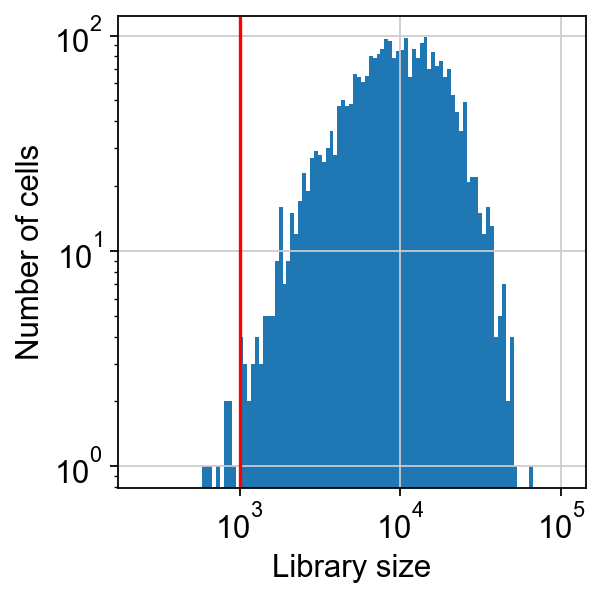

CPU times: total: 36.2 s
Wall time: 38.6 s


<Axes: xlabel='Library size', ylabel='Number of cells'>

In [24]:
%%time
activity_df = pd.DataFrame(adata.X.toarray(), index=adata.obs_names, columns=adata.var_names)
activity_df.to_csv('./data/activity_df.csv', index=True)
emt_data = scprep.io.load_csv('./data/activity_df.csv')
scprep.plot.plot_library_size(emt_data, cutoff=1000)

In [25]:
%%time
emt_data = scprep.filter.filter_library_size(emt_data, cutoff=1000)
emt_data = scprep.normalize.library_size_normalize(emt_data)
emt_data = scprep.transform.sqrt(emt_data)

magic_op = magic.MAGIC()
emt_magic = magic_op.fit_transform(emt_data)
emt_magic.to_csv('./data/emt_magic.csv', index=True)

#sce.pp.magic(adata, name_list='all_genes', knn=5)

Calculating MAGIC...
  Running MAGIC on 2861 cells and 15077 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.99 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.89 seconds.
    Calculating affinities...
    Calculated affinities in 0.90 seconds.
  Calculated graph and diffusion operator in 4.96 seconds.
  Running MAGIC with `solver='exact'` on 15077-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 2.88 seconds.
Calculated MAGIC in 8.03 seconds.
CPU times: total: 1min 37s
Wall time: 1min 14s


### Run PathSingle

In [26]:
cdata = sc.read('./data/emt_magic.csv', delimiter=',', cache=True) #emt_magic
calc_activity(cdata)

... writing an h5ad cache file to speedup reading next time
AnnData object with n_obs × n_vars = 2861 × 15077


100%|██████████| 573/573 [23:23<00:00,  2.45s/it]


### Cluster With KMeans

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


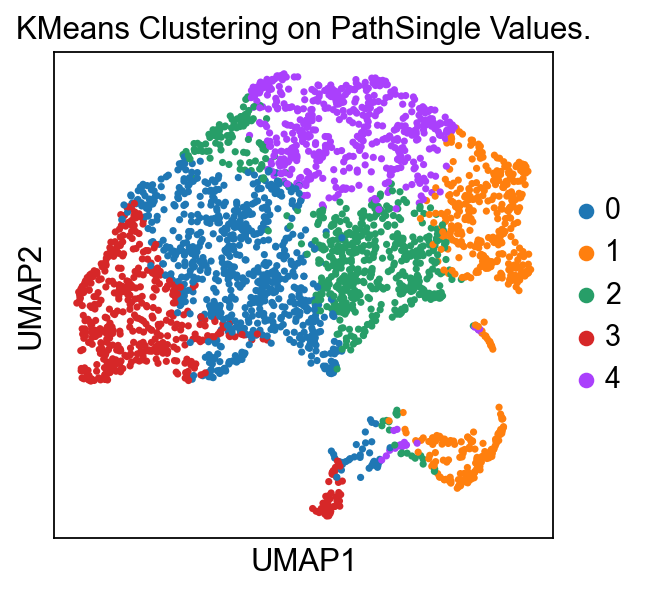

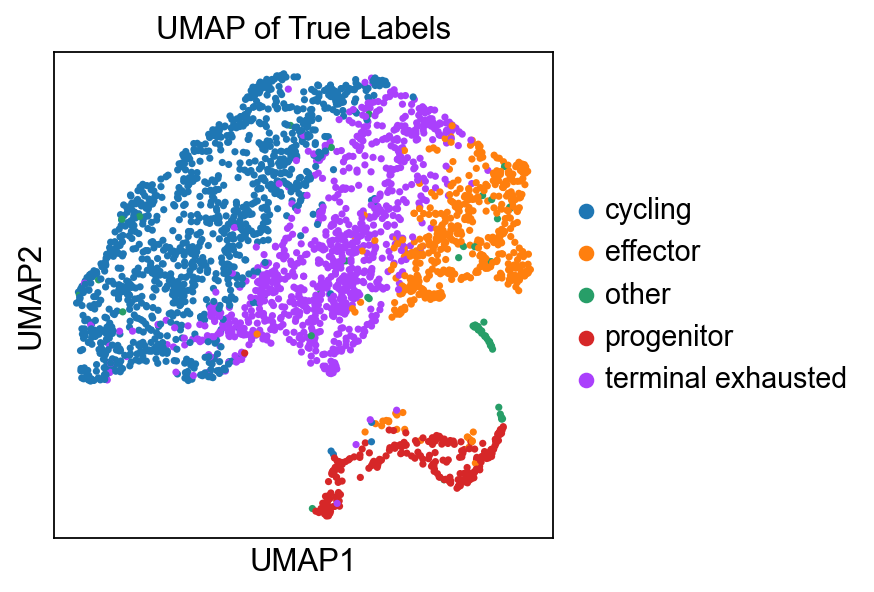

In [27]:
bdata = sc.read('./data/output_activity.csv', delimiter=',')

#Scale the data.
scaler = StandardScaler()
bdata.X = scaler.fit_transform(bdata.X)

#Perform KMeans clustering.
kmeans = KMeans(n_clusters=5, random_state=0).fit(bdata.X)
bdata.obs['kmeans'] = pd.Categorical(kmeans.labels_)

#Perform PCA and UMAP.
#umap_model = umap.UMAP(n_neighbors=15, random_state=0)
#umap_coords = umap_model.fit_transform(df)

#Perform PCA for Dimensionality Reduction.
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)
#Perform UMAP.
sc.pp.neighbors(bdata, n_neighbors=30, n_pcs=50)
sc.tl.umap(bdata, min_dist=0.3)

#Add the true labels from the original 'adata'.
bdata.obs['state'] = adata.obs.state

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(bdata, color=["kmeans"], title="KMeans Clustering on PathSingle Values.")
sc.pl.umap(bdata, color=["state"], title="UMAP of True Labels")
#sc.pl.umap(bdata, color=['state'], palette='Accent', legend_loc='right margin')

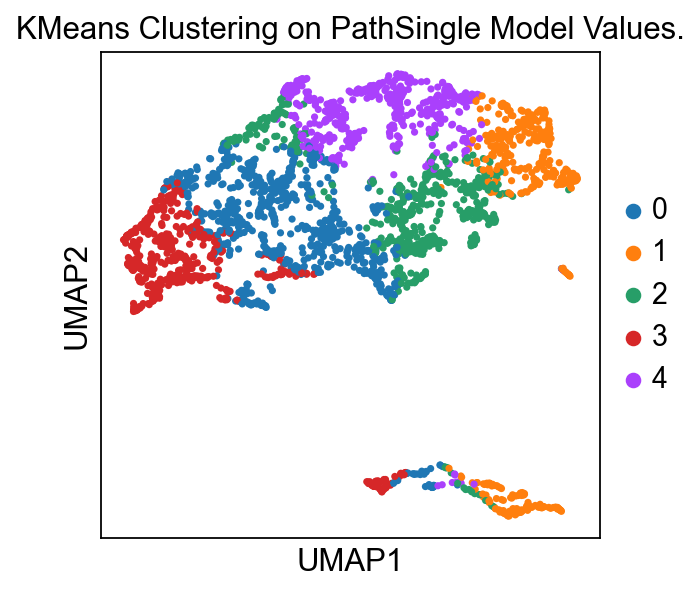

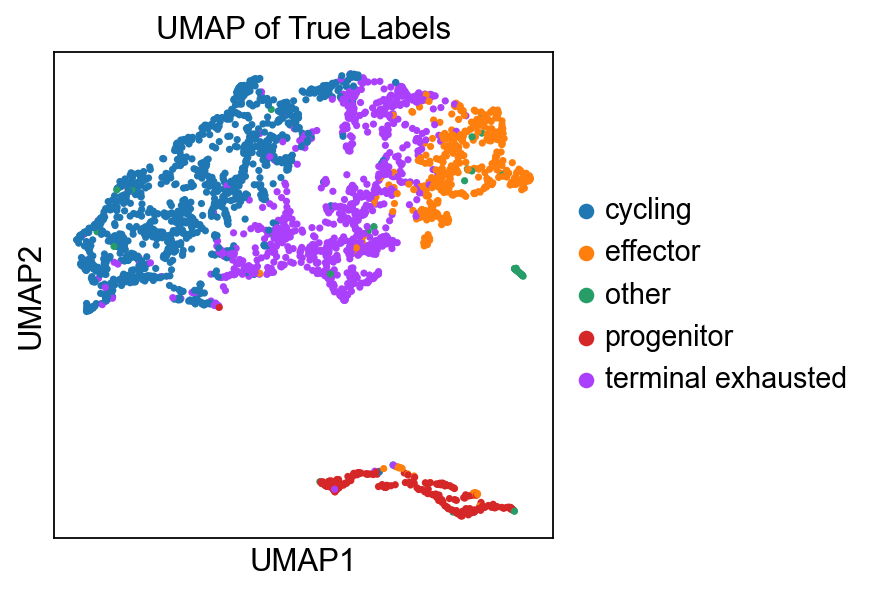

In [29]:
from sklearn.decomposition import PCA


output_activity = pd.read_csv('./data/output_activity.csv', index_col=0)

#Scale the data.
scaler = StandardScaler()
output_activity = scaler.fit_transform(output_activity)
PCA = PCA(n_components=50, svd_solver='arpack')
output_activty = PCA.fit_transform(output_activity)

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=5, random_state=0).fit(output_activity)

#Perform UMAP on the GSEA results matrix.
umap_model = umap.UMAP(n_neighbors=15) #For reproducability need to set , random_state=0, n_jobs=1.
umap_coords = umap_model.fit_transform(output_activity)

#Add the UMAP coordinates and clustering results to the AnnData object.
cdata.obsm['X_umap'] = umap_coords
cdata.obs['kmeans3'] = pd.Categorical(kmeans.labels_)
cell_state = adata.obs['state']
cdata.obs['state'] = cell_state[emt_magic.index].values #emt_magic

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(cdata, color=["kmeans3"], title="KMeans Clustering on PathSingle Model Values.")
sc.pl.umap(cdata, color=["state"], title="UMAP of True Labels")

In [30]:
%%time
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = output_activity

#Silhouette score.
silhouette_avg = silhouette_score(pathway_activity_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

#Calinski-Harabasz index.
calinski_harabasz = calinski_harabasz_score(pathway_activity_matrix, kmeans.labels_)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

#Dunn index.
dunn = dunn_index(pathway_activity_matrix, kmeans.labels_)
print(f"Dunn Index: {dunn}")

#Special accuracy function.
print(f"Special accuracy: {acc(cdata.obs.state.map({'cycling':0, 'effector':1, 'other':2, 'progenitor':3, 'terminal exhausted':4}), kmeans.labels_)}")
'''
Silhouette Score: 0.13966581225395203
Calinski-Harabasz Index: 4833.945701314397
0.40906714987629367
CPU times: total: 1min 11s
Wall time: 24.9 s
'''
'''
Silhouette Score: 0.15211382508277893
Calinski-Harabasz Index: 5655.742290248015
Dunn Index: 0.015291933212341749
0.39701014043279786

Silhouette Score: 0.14430435001850128
Calinski-Harabasz Index: 1041.2611092518353
Dunn Index: 0.03004235699635496
Special accuracy: 0.4415403380379857

Silhouette Score: 0.46754899621009827 (without normalization)
Calinski-Harabasz Index: 5878.325061479638
Dunn Index: 0.009056740202426312
Special accuracy: 0.3873497124934658
'''

Silhouette Score: 0.2192812338856287
Calinski-Harabasz Index: 1441.7075830818198
Dunn Index: 0.060069948227939256
Special accuracy: 0.3914715134568333
CPU times: total: 1.86 s
Wall time: 1.72 s


'\nSilhouette Score: 0.15211382508277893\nCalinski-Harabasz Index: 5655.742290248015\nDunn Index: 0.015291933212341749\n0.39701014043279786\n\nSilhouette Score: 0.14430435001850128\nCalinski-Harabasz Index: 1041.2611092518353\nDunn Index: 0.03004235699635496\nSpecial accuracy: 0.4415403380379857\n\nSilhouette Score: 0.46754899621009827 (without normalization)\nCalinski-Harabasz Index: 5878.325061479638\nDunn Index: 0.009056740202426312\nSpecial accuracy: 0.3873497124934658\n'

## PROGENy

In [50]:
import decoupler

#top: Desired top number of genes for each pathway according to their significance(p.value). Default to 100.
progeny = decoupler.get_progeny(organism='human', top=2000)
progeny.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


In [51]:
# Normalize gene names to lowercase.
adata.var_names = [gene.lower() for gene in adata.var_names]
progeny['target'] = progeny['target'].str.lower()

# Inspect unique gene names in both datasets.
unique_adata_genes = set(adata.var_names)
unique_progeny_genes = set(progeny['target'])

# Check overlap.
shared_genes = unique_adata_genes & unique_progeny_genes
print(f"Number of shared genes: {len(shared_genes)}")
print(f"Number of unique genes in adata: {len(unique_adata_genes)}")
print(f"Number of unique genes in progeny: {len(unique_progeny_genes)}")

# Identify missing genes.
missing_in_progeny = unique_adata_genes - unique_progeny_genes
missing_in_adata = unique_progeny_genes - unique_adata_genes
print(f"Genes in adata but not in progeny: {len(missing_in_progeny)}")
print(f"Genes in progeny but not in adata: {len(missing_in_adata)}")

print("Example genes in adata but not in progeny:", list(missing_in_progeny)[:10])
print("Example genes in progeny but not in adata:", list(missing_in_adata)[:10])

Number of shared targets: 9389
Number of unique genes in adata: 15077
Number of unique genes in progeny: 13865
Genes in adata but not in progeny: 5688
Genes in progeny but not in adata: 4476


In [53]:
# Filter mat to include only shared genes.
filtered_mat = adata[:, list(shared_genes)].copy()

# Check for empty features.
non_empty_features = filtered_mat[:, filtered_mat.X.sum(axis=0) > 0]

# Run PROGENy with the filtered matrix.
try:
    decoupler.run_mlm(
        mat=non_empty_features,
        net=progeny,
        source='source',
        target='target',
        weight='weight',
        verbose=True,
        use_raw=False
    )
except ValueError as e:
    print(e)
    print("Adjusting min_n parameter...")
    decoupler.run_mlm(
        mat=non_empty_features,
        net=progeny,
        source='source',
        target='target',
        weight='weight',
        verbose=True,
        use_raw=False,
        min_n=1  # Adjust this parameter as needed.
    )


Running mlm on mat with 5739 samples and 9281 targets for 14 sources.


### Cluster With KMeans

Pathway activity matrix shape: (5739, 14)


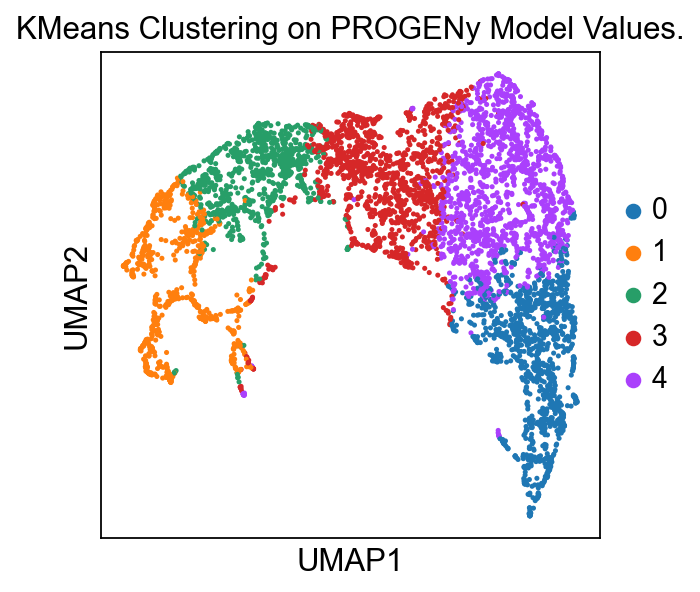

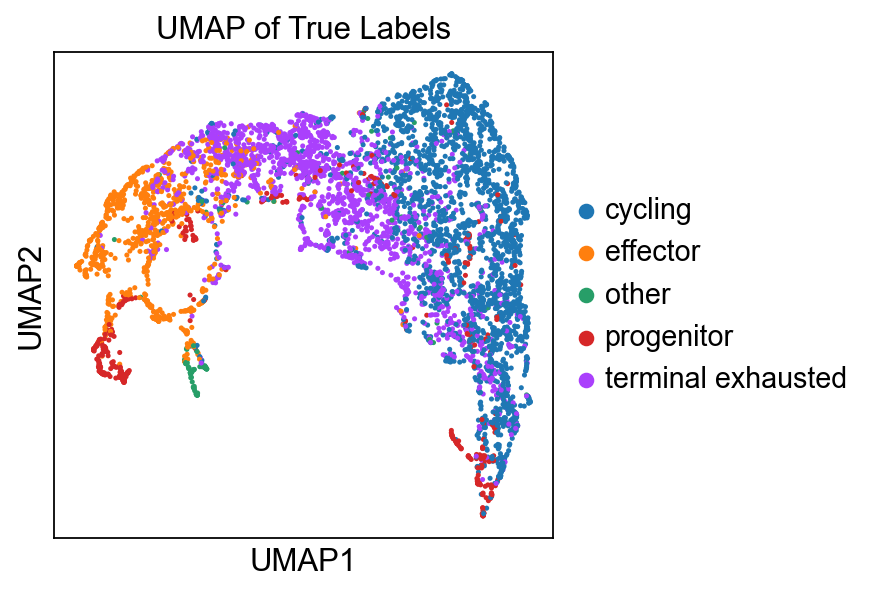

In [54]:
from sklearn.cluster import KMeans
import umap.umap_ as umap


acts = decoupler.get_acts(non_empty_features, obsm_key='mlm_estimate')

#Verify the structure of pathway activity matrix.
print("Pathway activity matrix shape:", acts.obsm['mlm_estimate'].shape)

#Convert the pathway activity matrix to a DataFrame.
pathway_activity_df = pd.DataFrame(
    acts.obsm['mlm_estimate'],
    index=adata.obs_names,
    columns=acts.var_names
)

#Add pathway activity to adata.obs.
#for pathway in acts.var_names:
    #adata.obs[pathway] = pathway_activity_df[pathway]

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=5, random_state=0).fit(pathway_activity_df)

#Perform UMAP on the GSEA results matrix.
umap_model = umap.UMAP(n_neighbors=15) #For reproducability need to set , random_state=0, n_jobs=1.
umap_coords = umap_model.fit_transform(pathway_activity_df)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['X_umap'] = umap_coords
adata.obs['kmeans3'] = pd.Categorical(kmeans.labels_)

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(adata, color=["kmeans3"], title="KMeans Clustering on PROGENy Model Values.")
sc.pl.umap(adata, color=["state"], title="UMAP of True Labels")

### Cluster Results

In [55]:
%%time
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = acts.obsm['mlm_estimate']

#Silhouette score.
silhouette_avg = silhouette_score(pathway_activity_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

#Calinski-Harabasz index.
calinski_harabasz = calinski_harabasz_score(pathway_activity_matrix, kmeans.labels_)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

#Dunn index.
dunn = dunn_index(pathway_activity_matrix, kmeans.labels_)
print(f"Dunn Index: {dunn}")

#Special accuracy function.
print(f"Special accuracy: {acc(adata.obs.state.map({'cycling':0, 'effector':1, 'other':2, 'progenitor':3, 'terminal exhausted':4}), kmeans.labels_)}")
'''
Silhouette Score: 0.10964662581682205
Calinski-Harabasz Index: 4611.1675632659235
Dunn Index: 0.04010670817222
0.43809457434575044
CPU times: total: 50.9 s
Wall time: 3min 44s

Silhouette Score: 0.10784872621297836
Calinski-Harabasz Index: 915.0039931963461
Dunn Index: 0.056072799197753806
Special accuracy: 0.4460707440320613
CPU times: total: 1.33 s
Wall time: 1.33 s

Silhouette Score: 0.1406594216823578
Calinski-Harabasz Index: 1264.6453096698822
Dunn Index: 0.0738300356213624
Special accuracy: 0.47255619445896496

Silhouette Score: 0.1678408831357956
Calinski-Harabasz Index: 1395.0839375526796
Dunn Index: 0.0664913042207824
Special accuracy: 0.527443805541035

Silhouette Score: 0.31864112615585327 (without normalization)
Calinski-Harabasz Index: 2969.8387111963275
Dunn Index: 0.010613224810574452
Special accuracy: 0.6354765638612999

Silhouette Score: 0.2656403183937073 (with normalization)
Calinski-Harabasz Index: 4772.814948414939
Dunn Index: 0.01198932258659006
Special accuracy: 0.4913748039728176
'''

Silhouette Score: 0.2656403183937073
Calinski-Harabasz Index: 4772.814948414939
Dunn Index: 0.01198932258659006
Special accuracy: 0.4913748039728176
CPU times: total: 1.17 s
Wall time: 1.19 s


'\nSilhouette Score: 0.10964662581682205\nCalinski-Harabasz Index: 4611.1675632659235\nDunn Index: 0.04010670817222\n0.43809457434575044\nCPU times: total: 50.9 s\nWall time: 3min 44s\n\nSilhouette Score: 0.10784872621297836\nCalinski-Harabasz Index: 915.0039931963461\nDunn Index: 0.056072799197753806\nSpecial accuracy: 0.4460707440320613\nCPU times: total: 1.33 s\nWall time: 1.33 s\n\nSilhouette Score: 0.1406594216823578\nCalinski-Harabasz Index: 1264.6453096698822\nDunn Index: 0.0738300356213624\nSpecial accuracy: 0.47255619445896496\n\nSilhouette Score: 0.1678408831357956\nCalinski-Harabasz Index: 1395.0839375526796\nDunn Index: 0.0664913042207824\nSpecial accuracy: 0.527443805541035\n\nSilhouette Score: 0.31864112615585327\nCalinski-Harabasz Index: 2969.8387111963275\nDunn Index: 0.010613224810574452\nSpecial accuracy: 0.6354765638612999\n'